In [1]:
import gym
import gym_snake
from matplotlib import pyplot as plt
import numpy as np
import cv2 as cv
import torch
import random
from helpers.feature_extraction import feature_vector, find_apple_coordinates_pixel_array, distances_to_walls
from helpers.genetic_algorithms import GameNet, create_mating_pool, create_population, calculate_fitness



# Construct Environment
env = gym.make('snake-v0')
env.grid_size = 15, 15
observation = env.reset()  # Constructs an instance of the game

# Controller
game_controller = env.controller

# Grid
grid_object = game_controller.grid
grid_pixels = grid_object.grid

# Snake(s)
snakes_array = game_controller.snakes
snake_object1 = snakes_array[0]

observation = env.reset()
to_pixels = lambda x: cv.resize(x, env.grid_size)
    

In [2]:
print(torch.cuda.is_available())
cuda = torch.device('cuda:0')

True


In [3]:
print(feature_vector(snake_object1, grid_object.grid, env.grid_size, grid_object.FOOD_COLOR))

ValueError: all the input arrays must have same number of dimensions

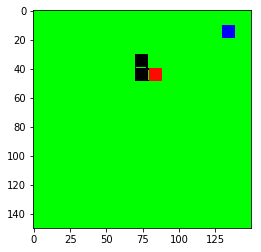

In [4]:
plt.imshow(env.step(snake_object1.RIGHT)[0])

c:\users\sofik\appdata\local\programs\python\python37\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


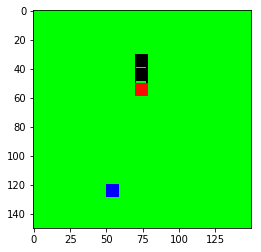

Best result: 1
Best result: 1
Best result: 1
Best result: 1
Best result: 1
Best result: 1
Best result: 1


In [ ]:
#Initial population + configurations
n_individuals = 120
n_generations = 20
population = create_population(n_individuals)
percentage_to_save = .3


for i in range(n_generations):
    new_generation = []
    fitness = []
    for i in range(len(population)):
        fit_score = calculate_fitness(population[i], env)
        fitness.append(fit_score)
    print("Best result:", max(fitness))
    mating_pool = create_mating_pool(fitness, population, int(percentage_to_save * n_individuals))
    new_generation = []
    while len(new_generation) < n_individuals:
        sample = random.sample(mating_pool, 2)
        parent1, parent2 = sample[0], sample[1]
        child1, child2 = parent1.crossover(parent2)
        child1.mutate()
        child2.mutate()
        new_generation += [child1, child2]
    population = new_generation
